In [1]:
import sys
sys.executable


'/usr/local/bin/python3'

In [2]:
# Import pandas sqlite3 matplotlib seaborn
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_confint
import scipy.stats as stats 
from itertools import combinations



In [3]:
# Import Kagglehub API and get data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("catherinerasgaitis/mxmh-survey-results")

print("Path to dataset files:", path)

Path to dataset files: /Users/luckyc/.cache/kagglehub/datasets/catherinerasgaitis/mxmh-survey-results/versions/1


In [4]:
# Create a dataframe from CSV obtained in kagglehub API for survey results 
survey = pd.read_csv("mxmh_survey_results.csv")

# Show first two lines
survey.head(2)

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.


In [5]:
# reading in survey data manipulated in sql to have columns wanted
survey_sql = pd.read_csv("mxmh_survey.csv")

# Show the first two lines
survey_sql.head(2)

,Age,Primarystreamingservice,Favgenre,BPM,Anxiety,Depression,Insomnia,OCD,Musiceffects
0,18.0,spotify,latin,156.0,3.0,0.0,1.0,0.0,NaN
1,18.0,spotify,video game music,132.0,7.0,7.0,10.0,2.0,No effect


In [6]:
# Check for isnull
survey_sql.isnull().any().any()

np.True_

In [7]:
# Checking where isnull values are located
survey_sql.isnull().sum()

Age                         1
Primarystreamingservice     0
Favgenre                    0
BPM                        56
Anxiety                     0
Depression                  0
Insomnia                    0
OCD                         0
Musiceffects                3
dtype: int64

In [8]:
# removing isnull items and reseting index as well and renaming with _cleaned
survey_sql_cleaned = survey_sql.dropna().reset_index(drop=True)

In [9]:
survey_sql_cleaned.head(2)

,Age,Primarystreamingservice,Favgenre,BPM,Anxiety,Depression,Insomnia,OCD,Musiceffects
0,18.0,spotify,video game music,132.0,7.0,7.0,10.0,2.0,No effect
1,18.0,spotify,r&b,107.0,7.0,2.0,5.0,9.0,Improve


In [10]:
survey_sql_cleaned.shape

(400, 9)

In [11]:
# reading in survey data manipulated in sql to have columns wanted
survey_db_counts = pd.read_csv('survey_db_update.csv')

# Show the first two lines
survey_db_counts.head(2)


,Primarystreamingservice,Favgenre,improve_count,worsen_count,no_effect_count,total_count
0,spotify,classical,17,1,7,25
1,spotify,country,12,0,3,15


In [12]:
# checking for null

survey_db_counts.isnull().any().any() 

np.False_

In [13]:
def calculate_percentage(survey_db_counts):
    # Calculate percentages
    survey_db_counts['improve_percentage'] = ((survey_db_counts['improve_count'] / survey_db_counts['total_count']) * 100).round(2)
    survey_db_counts['worsen_percentage'] = ((survey_db_counts['worsen_count'] / survey_db_counts['total_count']) * 100).round(2)
    survey_db_counts['no_effect_percentage'] = ((survey_db_counts['no_effect_count'] / survey_db_counts['total_count']) * 100).round(2)

    # Return the DataFrame with the new columns
    return survey_db_counts[['Favgenre', 'total_count', 'improve_percentage', 'worsen_percentage', 'no_effect_percentage']]



In [14]:
# call the function

percentages = calculate_percentage(survey_db_counts)

percentages

,Favgenre,total_count,improve_percentage,worsen_percentage,no_effect_percentage
0,classical,25,68.00,4.00,28.00
1,country,15,80.00,0.00,20.00
2,edm,21,80.95,0.00,19.05
3,folk,20,75.00,0.00,25.00
4,gospel,2,100.00,0.00,0.00
5,hip hop,28,92.86,0.00,7.14
6,jazz,15,86.67,0.00,13.33
7,k pop,22,72.73,0.00,18.18
8,latin,2,0.00,0.00,50.00
9,lofi,8,100.00,0.00,0.00


In [15]:


# Assume 'df' is your DataFrame and 'improve_count', 'total_count', 'playlist_genre' are columns
# Calculate the improve percentage for each genre
survey_db_counts['improve_percentage'] = (survey_db_counts['improve_count'] / survey_db_counts['total_count']) * 100

# Calculate the confidence intervals for each genre
ci_results = []
for genre in survey_db_counts['Favgenre'].unique():
    genre_data = survey_db_counts[survey_db_counts['Favgenre'] == genre]
    n = genre_data['total_count'].sum()  # total number of votes for this genre
    successes = genre_data['improve_count'].sum()  # total number of improvements for this genre
    
    # Calculate confidence intervals using the Wilson score interval
    lower, upper = proportion_confint(successes, n, alpha=0.05, method='wilson')
    
    # Store the results (mean, lower CI, upper CI)
    mean_percentage = (successes / n) * 100
    ci_results.append((genre, mean_percentage, lower * 100, upper * 100))

# Convert the results to a DataFrame for easier inspection
ci_df = pd.DataFrame(ci_results, columns=['Genre', 'Improve Percentage', 'Lower CI', 'Upper CI'])
print(ci_df)




               Genre  Improve Percentage   Lower CI    Upper CI
0          classical           68.000000  48.410269   82.794810
1            country           80.000000  54.814551   92.952451
2                edm           80.952381  59.999435   92.332435
3               folk           75.000000  53.129912   88.813830
4             gospel          100.000000  34.238023  100.000000
5            hip hop           92.857143  77.354637   98.018794
6               jazz           86.666667  62.118017   96.263874
7              k pop           72.727273  51.848266   86.849240
8              latin            0.000000   0.000000   65.761977
9               lofi          100.000000  67.559244  100.000000
10             metal           80.327869  68.690059   88.372198
11               pop           76.470588  65.144832   84.965509
12               r&b           73.913043  53.529995   87.451384
13               rap           75.000000  46.769467   91.105833
14              rock           69.491525

In [16]:
print(ci_df)

               Genre  Improve Percentage   Lower CI    Upper CI
0          classical           68.000000  48.410269   82.794810
1            country           80.000000  54.814551   92.952451
2                edm           80.952381  59.999435   92.332435
3               folk           75.000000  53.129912   88.813830
4             gospel          100.000000  34.238023  100.000000
5            hip hop           92.857143  77.354637   98.018794
6               jazz           86.666667  62.118017   96.263874
7              k pop           72.727273  51.848266   86.849240
8              latin            0.000000   0.000000   65.761977
9               lofi          100.000000  67.559244  100.000000
10             metal           80.327869  68.690059   88.372198
11               pop           76.470588  65.144832   84.965509
12               r&b           73.913043  53.529995   87.451384
13               rap           75.000000  46.769467   91.105833
14              rock           69.491525

Based on the confidence intervals lower and upper there is no way to state which genre has the best type of music that improves mental health. it is likely that whatever music you like to listen to improves your mood. As a result I will select the top 2 songs for each genre according to spotify

In [17]:


def p(survey_db_counts):
    # Calculate the percentages for improve, worsen, and no effect
    survey_db_counts['improve_percentage'] = (survey_db_counts['improve_count'] / survey_db_counts['total_count']) * 100
    survey_db_counts['worsen_percentage'] = (survey_db_counts['worsen_count'] / survey_db_counts['total_count']) * 100
    survey_db_counts['no_effect_percentage'] = (survey_db_counts['no_effect_count'] / survey_db_counts['total_count']) * 100

    # Create a list to store results for all pairwise z-tests
    pairwise_results = []

    # Generate pairwise combinations of genres
    genre_combinations = combinations(survey_db_counts['Favgenre'], 2)
    
    for genre1, genre2 in genre_combinations:
        # Extract the data for each genre pair
        group1 = survey_db_counts[survey_db_counts['Favgenre'] == genre1]
        group2 = survey_db_counts[survey_db_counts['Favgenre'] == genre2]

        # Perform z-test for proportions (two-sample test)
        counts_improve = [group1['improve_count'].sum(), group2['improve_count'].sum()]
        totals_improve = [group1['total_count'].sum(), group2['total_count'].sum()]

        z_stat, p_value = proportions_ztest(counts_improve, totals_improve)

        # Append the results for this pairwise comparison
        pairwise_results.append({
            'genre1': genre1,
            'genre2': genre2,
            'z_stat': z_stat,
            'p_value': p_value
        })

    # Return pairwise comparison results along with the original DataFrame
    pairwise_survey = pd.DataFrame(pairwise_results)

    return survey_db_counts[['Favgenre', 'total_count', 'improve_percentage']], pairwise_survey


 #  df = pd.DataFrame(data)

# Call the function and capture the result
result, pairwise_results = p(survey_db_counts)

# Display the result DataFrame and pairwise comparison results
result
pairwise_results


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


,genre1,genre2,z_stat,p_value
0,classical,country,-0.822871,0.410582
1,classical,edm,-0.996502,0.319006
2,classical,folk,-0.514805,0.606689
3,classical,gospel,-0.953663,0.340254
4,classical,hip hop,-2.308894,0.020949
...,...,...,...,...
115,r&b,rock,0.424174,0.671439
116,r&b,video game music,1.230154,0.218639
117,rap,rock,0.396718,0.691576
118,rap,video game music,1.082704,0.278940


/var/folders/sw/mf1x4fnn1jg2jq5n72k6mkm80000gn/T/ipykernel_54157/4010961338.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result, x='Favgenre', y='improve_percentage', palette='viridis')


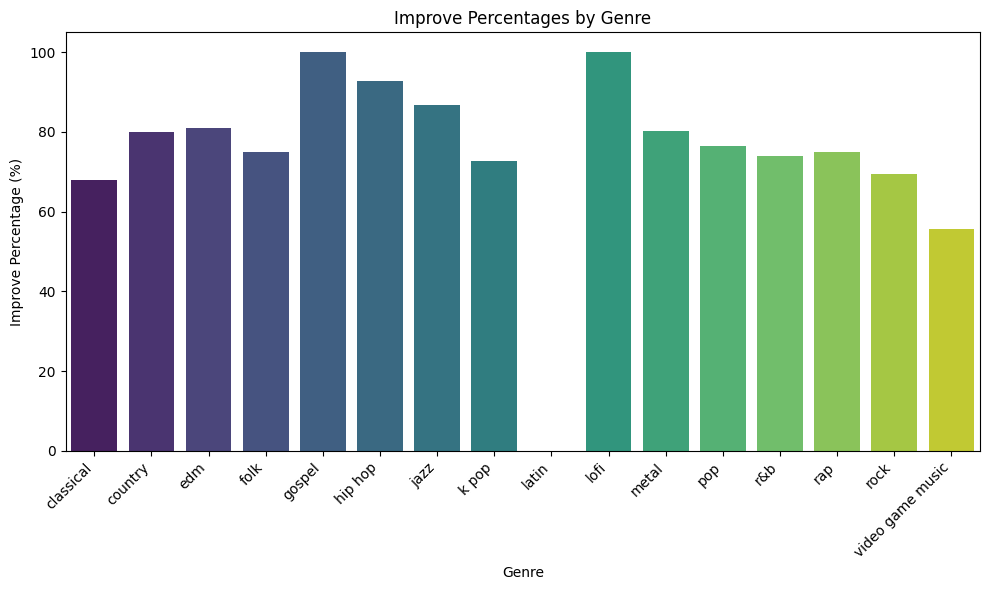

In [18]:

# Bar plot for improve percentages by genre
plt.figure(figsize=(10, 6))
sns.barplot(data=result, x='Favgenre', y='improve_percentage', palette='viridis')
plt.title('Improve Percentages by Genre')
plt.xlabel('Genre')
plt.ylabel('Improve Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [19]:
avg_improve_percentage = result['improve_percentage'].mean()
print(f"Average Improve Percentage: {avg_improve_percentage:.2f}%")



Average Improve Percentage: 74.19%


In [20]:
significant_comparisons = pairwise_results[pairwise_results['p_value'] < 0.05]
print(f"Significant Pairwise Comparisons: \n{significant_comparisons}")


Significant Pairwise Comparisons: 
        genre1            genre2    z_stat   p_value
4    classical           hip hop -2.308894  0.020949
21     country             latin  2.332381  0.019681
34         edm             latin  2.491255  0.012729
46        folk             latin  2.171241  0.029913
57      gospel             latin  2.000000  0.045500
67     hip hop             latin  3.732100  0.000190
73     hip hop              rock  2.533203  0.011303
74     hip hop  video game music  2.993438  0.002759
76        jazz             latin  2.714160  0.006644
84       k pop             latin  2.088932  0.036714
92       latin              lofi -3.162278  0.001565
93       latin             metal -2.688774  0.007171
94       latin               pop -2.438793  0.014736
95       latin               r&b -2.149317  0.031609
96       latin               rap -2.049390  0.040424
97       latin              rock -2.094979  0.036173
104       lofi  video game music  2.266231  0.023437
109      me

In [21]:
# Create a dataframe for high popularity spotify
high_spotify = pd.read_csv("high_popularity_spotify_data.csv")

# Show first two lines
high_spotify.head(2)

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3,0.0304,...,0.0000,10FLjwfpbxLmW8c25Xyc2N,0,6,251668,0.308,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4,0.0358,...,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1,2,210373,0.200,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


In [22]:
# Create a dataframe for low popularity spotify
low_spotify = pd.read_csv("low_popularity_spotify_data.csv")

# Show first two lines
low_spotify.head(2)

,time_signature,track_popularity,speechiness,danceability,playlist_name,track_artist,duration_ms,energy,playlist_genre,playlist_subgenre,...,track_album_id,playlist_id,track_id,valence,key,tempo,loudness,acousticness,liveness,track_album_name
0,4.0,23,0.0393,0.636,Rock Classics,Creedence Clearwater Revival,138053.0,0.746,rock,classic,...,4A8gFwqd9jTtnsNwUu3OQx,37i9dQZF1DWXRqgorJj26U,5e6x5YRnMJIKvYpZxLqdpH,0.432,0.0,132.310,-3.785,0.0648,0.1730,The Long Road Home - The Ultimate John Fogerty...
1,4.0,53,0.0317,0.572,Rock Classics,Van Halen,241600.0,0.835,rock,classic,...,2c965LEDRNrXXCeBOAAwns,37i9dQZF1DWXRqgorJj26U,5FqYA8KfiwsQvyBI4IamnY,0.795,0.0,129.981,-6.219,0.1710,0.0702,The Collection


In [23]:
union_spotify = pd.read_csv('union_spotify.csv')

union_spotify.head(2)

,energy,tempo,danceability,liveness,valence,duration_ms,loudness,playlist_genre,track_name,track_artist,track_popularity,analysis_url
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lofi,Make It,Berhanio,50,NaN
1,0.000202,71.599,0.124,0.11,0.0346,186388.0,-43.713,ambient,Foundation,Matheo Lyon,61,https://api.spotify.com/v1/audio-analysis/15Tw...


In [24]:
union_spotify.shape

(4676, 12)

In [25]:
# check for additional isnull
union_spotify.isnull().any().any()

np.True_

In [26]:
# Check where null is located
union_spotify.isnull().sum()

energy              1
tempo               1
danceability        1
liveness            1
valence             1
duration_ms         1
loudness            1
playlist_genre      0
track_name          0
track_artist        0
track_popularity    0
analysis_url        1
dtype: int64

In [27]:
union_spotify_clean = union_spotify.dropna().reset_index(drop=True)

union_spotify_clean.head(2)

,energy,tempo,danceability,liveness,valence,duration_ms,loudness,playlist_genre,track_name,track_artist,track_popularity,analysis_url
0,0.000202,71.599,0.124,0.11,0.0346,186388.0,-43.713,ambient,Foundation,Matheo Lyon,61,https://api.spotify.com/v1/audio-analysis/15Tw...
1,0.000237,73.664,0.172,0.11,0.0383,195466.0,-44.525,ambient,Reconcile,Jan Garlow,61,https://api.spotify.com/v1/audio-analysis/3ICe...


In [28]:
union_spotify_clean.shape

(4675, 12)

In [29]:
# Setting up for correlation matrix
unioned_filtered_numeric = union_spotify_clean.select_dtypes(include=['number'])
# survey_filtered_numeric = survey_db_counts.select_dtypes(include=['number'])

# Correlation Matrix
corr_matrix = unioned_filtered_numeric.corr()

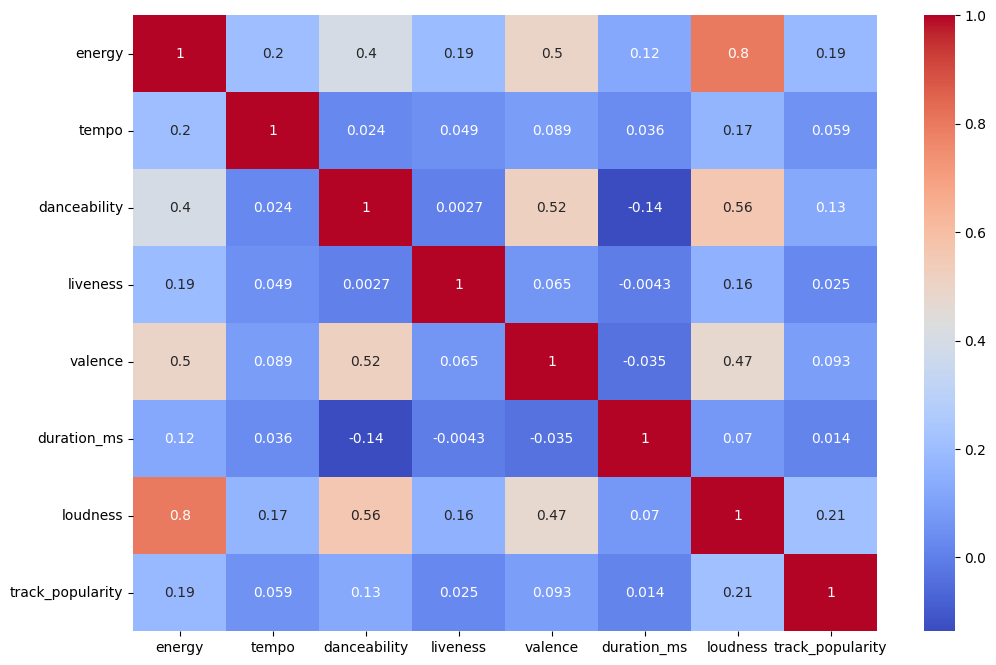

In [30]:
# Plot the heatmap  
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [31]:
# Setting up for correlation matrix
survey_filtered_numeric = survey_sql_cleaned.select_dtypes(include=['number'])
# survey_filtered_numeric = survey_db_counts.select_dtypes(include=['number'])

# Correlation Matrix
corr_matrix_survey = survey_filtered_numeric.corr()

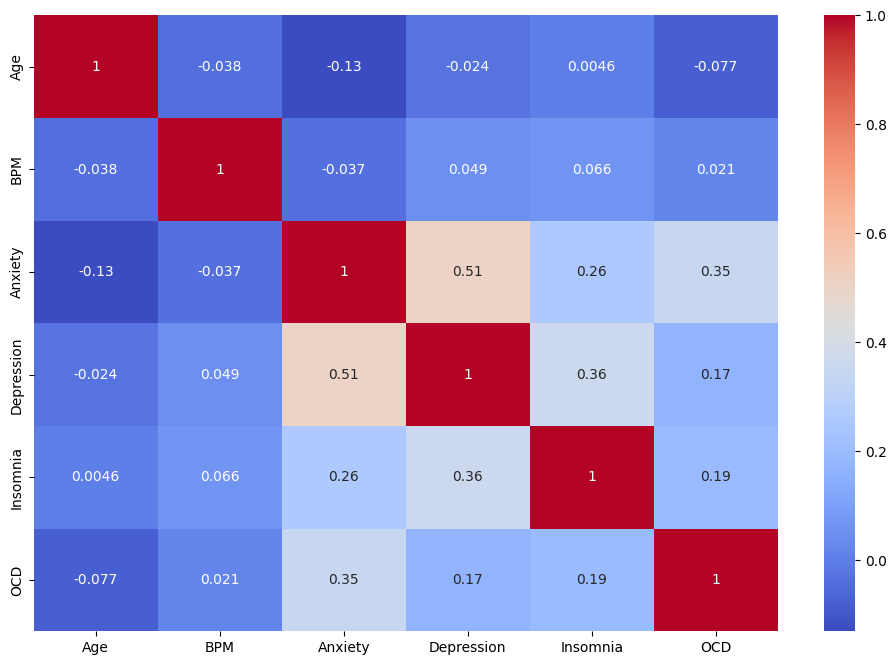

In [32]:
# Plot the heatmap  
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix_survey, annot=True, cmap='coolwarm')
plt.show()

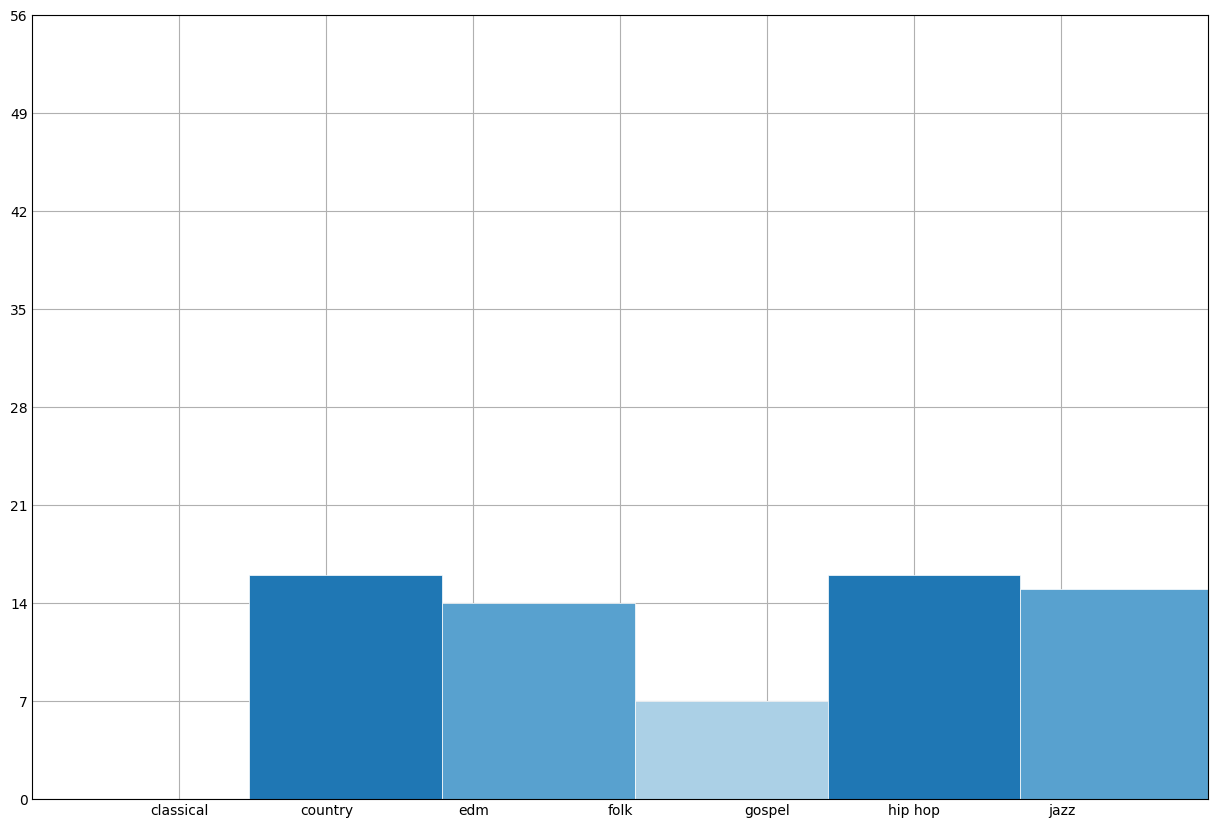

In [33]:
# histogram
plt.style.use('_mpl-gallery')

# plot:
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(survey_db_counts, bins=8, linewidth=0.5, edgecolor="white")

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 56), yticks=np.linspace(0, 56, 9))

plt.show()

In [34]:
survey_db_counts.columns

Index(['Primarystreamingservice', 'Favgenre', 'improve_count', 'worsen_count',
       'no_effect_count', 'total_count', 'improve_percentage',
       'worsen_percentage', 'no_effect_percentage'],
      dtype='object')

In [35]:
unique_values = union_spotify_clean['playlist_genre'].unique()
print(unique_values)

['ambient' 'wellness' 'gaming' 'world' 'classical' 'electronic' 'lofi'
 'jazz' 'folk' 'blues' 'pop' 'soul' 'latin' 'arabic' 'rock' 'afrobeats'
 'cantopop' 'r&b' 'hip-hop' 'mandopop' 'brazilian' 'korean' 'turkish'
 'disco' 'country' 'indian' 'punk' 'j-pop' 'reggae' 'gospel' 'k-pop'
 'indie' 'funk' 'soca' 'metal']


In [36]:
print(len(survey_filtered_numeric))
print(len(unioned_filtered_numeric))

400
4675


In [37]:
popular_over_70 = pd.read_csv('popular_over_70.csv')

popular_categories = pd.read_csv('popular_categories.csv')

In [38]:
popular_over_70.head()

,playlist_genre,track_name,track_artist,track_popularity,analysis_url
0,pop,Die With A Smile,"Lady Gaga, Bruno Mars",100,https://api.spotify.com/v1/audio-analysis/2plb...
1,pop,BIRDS OF A FEATHER,Billie Eilish,97,https://api.spotify.com/v1/audio-analysis/6dOt...
2,pop,That’s So True,Gracie Abrams,93,https://api.spotify.com/v1/audio-analysis/7ne4...
3,pop,Taste,Sabrina Carpenter,81,https://api.spotify.com/v1/audio-analysis/1d7P...
4,pop,APT.,"ROSÉ, Bruno Mars",98,https://api.spotify.com/v1/audio-analysis/5vNR...


In [39]:
popular_categories.head()

,playlist_genre,track_name,track_artist,track_popularity,analysis_url
0,pop,Die With A Smile,"Lady Gaga, Bruno Mars",100,https://api.spotify.com/v1/audio-analysis/2plb...
1,pop,BIRDS OF A FEATHER,Billie Eilish,97,https://api.spotify.com/v1/audio-analysis/6dOt...
2,pop,That’s So True,Gracie Abrams,93,https://api.spotify.com/v1/audio-analysis/7ne4...
3,pop,Taste,Sabrina Carpenter,81,https://api.spotify.com/v1/audio-analysis/1d7P...
4,pop,APT.,"ROSÉ, Bruno Mars",98,https://api.spotify.com/v1/audio-analysis/5vNR...


In [40]:

popular_songs_by_genre = pd.read_csv('max_popular_songs.csv')

In [41]:
popular_songs_by_genre.isnull().any().any()

np.False_

In [42]:
popular_songs_by_genre.shape

(37, 6)

In [43]:
# Filtering for most popular song by genre in the spotify database (from sql csv)

def filter_by_genre(df, column_name, genre):
    """ Filtering by column genre to find the top song for that genre based on popular spotify data.
    
    Parameters:
    df = The DataFrame that houses the data
    column_name = column that is being filtered
    genre = The genre to search
   
     Returns:
    pandas.DataFrame: A filtered DataFrame containing rows where the genre matches the given genre.
    """
    

    filtered_popular_songs = popular_songs_by_genre[popular_songs_by_genre['playlist_genre'] == genre]
    return filtered_popular_songs




In [44]:
result_popular = filter_by_genre(popular_songs_by_genre, 'playlist_genre', 'metal')
result_popular

,playlist_genre,track_popularity,track_artist,track_popularity.1,track_name,analysis_url
15,metal,83,System Of A Down,83,Chop Suey!,https://api.spotify.com/v1/audio-analysis/2DlH...
21,metal,83,System Of A Down,83,Chop Suey!,https://api.spotify.com/v1/audio-analysis/2DlH...


In [45]:



duplicates_popular_songs_by_genre = popular_songs_by_genre[popular_songs_by_genre.duplicated(keep=False)]

duplicates_popular_songs_by_genre.shape

(10, 6)

In [46]:
# Drop duplicates and create a new DataFrame
popular_songs_by_genre_no_duplicates = popular_songs_by_genre.drop_duplicates()

popular_songs_by_genre_clean = popular_songs_by_genre_no_duplicates

In [47]:
popular_songs_by_genre_clean.shape

(32, 6)

In [48]:
# Filtering for most popular song by genre in the spotify database (from sql csv)

def filter_by_genre(df, column_name, genre):
    """ Filtering by column genre to find the top song for that genre based on popular spotify data.
    
    Parameters:
    df = The DataFrame that houses the data
    column_name = column that is being filtered
    genre = The genre to search
   
     Returns:
    pandas.DataFrame: A filtered DataFrame containing rows where the genre matches the given genre.
    """
    

    filtered_popular_songs = popular_songs_by_genre_clean[popular_songs_by_genre_clean['playlist_genre'] == genre]
    return filtered_popular_songs

In [49]:
result_popular = filter_by_genre(popular_songs_by_genre_clean, 'playlist_genre', 'jazz')
result_popular


,playlist_genre,track_popularity,track_artist,track_popularity.1,track_name,analysis_url
1,jazz,69,Nat King Cole,69,Unforgettable,https://api.spotify.com/v1/audio-analysis/648T...


In [50]:
unique_spotify_genres = popular_songs_by_genre_clean['playlist_genre'].unique()

unique_spotify_genres

array(['pop', 'jazz', 'classical', 'hip-hop', 'afrobeats', 'latin',
       'indian', 'country', 'r&b', 'electronic', 'soul', 'gaming',
       'j-pop', 'metal', 'reggae', 'k-pop', 'arabic', 'rock', 'punk',
       'blues', 'folk', 'lofi', 'brazilian', 'turkish', 'ambient',
       'korean', 'world', 'indie'], dtype=object)

In [51]:
# survey db counts
unique_survey_db_counts = survey_db_counts['Favgenre'].unique()

unique_survey_db_counts

array(['classical', 'country', 'edm', 'folk', 'gospel', 'hip hop', 'jazz',
       'k pop', 'latin', 'lofi', 'metal', 'pop', 'r&b', 'rap', 'rock',
       'video game music'], dtype=object)

Will focus on the values that are common between unique_spotify_genres and unique_survey_db_counts
with attempted join

In [52]:
# y, sr = librosa.load('Unforgettable_NKC_NC.wav', mono=False)

# Compute the spectrogram
# spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibels
# spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)




In [53]:
import ffmpeg

input_file = 'Unforgettable.wav'
output_file = 'converted_audio.wav'

# Convert to PCM WAV format using FFmpeg
ffmpeg.input(input_file).output(output_file, acodec='pcm_s16le').run()

print("File converted successfully")


ModuleNotFoundError: No module named 'ffmpeg'

In [ ]:
# Load audio file
sample_rate, audio_data = wavfile.read('Unforgettable.wav')



In [ ]:
# Plot the waveform
plt.figure(figsize=(12, 6))
librosa.display.waveshow(y, sr=sr)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis=time, y_axis=hz)
plt.colorbar(format=%+2.0f dB)
plt.title(Spectrogram)
plt.tight_layout()
plt.show()